In [ ]:
!apt install python3-rtree --quiet
!pip install osmnx
!pip install geopandas
!pip install matplotlib

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from descartes import PolygonPatch
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import networkx as nx
import osmnx as ox
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import random as rd
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/usr/local/lib/python3.8/dist-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


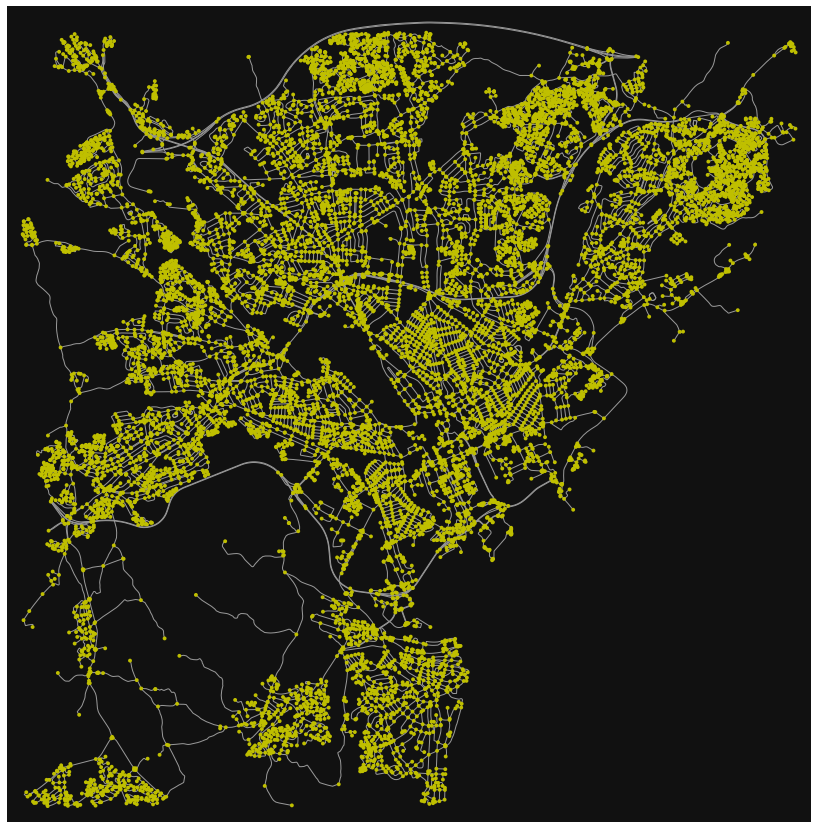

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot: >)

In [ ]:
ox.config(log_console=True, use_cache=True)
G = ox.graph_from_address('Cardiff Castle, Cardiff',dist=7000, network_type='drive')
nodes_proj, edges_proj = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)
G = G.to_undirected()
ox.plot_graph(G, node_color='y',  figsize = (15,15))

In [ ]:
newG=nx.empty_graph(n=0,create_using=nx.MultiGraph())
for i in list(G.nodes):
  hub_ego = nx.ego_graph(G, i, radius = 1500, center=True, undirected=True, distance = "length")
  for j in list(hub_ego.nodes):
    newG.add_edge(i,j)

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
N = []
D = []
NB = []
for v in nx.nodes(G):
  N.append(v)
  D.append(nx.degree(G, v))
  nb = [n for n in G.neighbors(v)]
  NB.append(nb)
data_tuples = list(zip(N,D,NB))

df = pd.DataFrame(data_tuples, columns=['Node','Degree', 'Neighbors']).sort_values('Degree', ascending=[False]).reset_index()
del df['index']
avgd = int(df['Degree'].mean())  #Average degree
alpha = min(df['Degree'])   #min degree
print(df,"\n\n", 'Avg degree is: ', avgd, "\n", 'Min degree is(alpha): ', alpha)

              Node  Degree                                          Neighbors
0        410086865       8  [30943844, 260306446, 30943648, 1085345564, 41...
1        244021466       5  [244022925, 244022894, 2969203198, 1993605844,...
2         30994770       5  [30994769, 2570565851, 30970083, 291953109, 22...
3       1357163755       5                           [1357163755, 1357163756]
4        260093702       5                             [260093701, 260093702]
...            ...     ...                                                ...
12579   1366773803       1                                       [1366773825]
12580    457695057       1                                       [5095474262]
12581   1366773816       1                                       [1366773807]
12582   1366773819       1                                       [1366773828]
12583  10275199703       1                                      [10273679062]

[12584 rows x 3 columns] 

 Avg degree is:  2 
 Min degree is(a

In [ ]:
import random

def dominating_set(graph,k): #randomized k-dominated algorithm
  all_nodes = set(graph)
  A = []

#calculating probability
  def nCr(n, r):       #nCr
    return (fact(n) / (fact(r) * fact(n - r)))
  def fact(n):
    if n == 0:
      return 1
    res = 1
    for i in range(2, n+1):
      res = res * i     
    return res

  alphadash = avgd - k + 1
  r1 = nCr(avgd, k-1)
  root = np.power(r1*(1 + alphadash),(1/alphadash))
  p = 1 - (1/root)
##################################################################################

  for i in df['Node']: # A set
    rn = (random.randint(0,100)/100)
    if rn < p:
      A.append(i)
  #print("First list", A, len(A))
  rem_nodes = all_nodes - set(A) # remaining nodes


#Another set B via algorithm
  N2=[]
  D2=[]
  for v in rem_nodes:
    N2.append(v)
    D2.append(nx.degree(graph, v))
  data_tuples2 = list(zip(N2,D2))

  df2 = pd.DataFrame(data_tuples2, columns=['Node','Degree']).sort_values('Degree', ascending=[False]).reset_index()
  del df2['index']

  for i in df2['Node']:                     #checking from rem_nodes
    counter = 0
    nb = [n for n in graph.neighbors(i)]        #list of neighbors

    for j in nb:                             #checking each element in neighbours list with setA
      if j in A:
        counter+=1

    if counter < k:
      A.append(i)
  return A


In [ ]:
def greedytry(graph,k):
  D=[]
  tbd=[]
  rem_nodes = list(df['Node'])
  for rn in rem_nodes:
    c=0
    nn = [n for n in graph.neighbors(rn)]
    nn=set(nn) - set(tbd)

    for j in nn:
      if (j in nn) and (j in D): 
        c+=1
    if c<k:
      D.append(rn)
      tbd = list(set(nn) | set([rn]))
      rem_nodes = set(rem_nodes) - set(tbd)
  return D

In [ ]:
from itertools import chain

def is_dominating_set(G, nbunch): # function to check whether dominating set
    testset = {n for n in nbunch if n in G}
    nbrs = set(chain.from_iterable(G[n] for n in testset))
    if len(set(G) - testset - nbrs) == 0:
      return 1
    else:
      return 0

In [ ]:
def minimal(G , D): #minimal K dominating set
  N=[]
  L = []
  for d in D:
    nb = [n for n in G.neighbors(d)]
    abc = set(nb) - set(D)
    N.append(d)
    L.append(len(abc))
  data_tuples = list(zip(N,L))

  df_min = pd.DataFrame(data_tuples, columns=['Node','N[v]-D']).sort_values('N[v]-D', ascending=[False]).reset_index()
  del df_min['index']
  #print(df_min)
  nodes = list(df_min['Node'])

  for i in nodes:
    mds = set(D) - set([i])
    y = is_dominating_set(G, mds)

    if y == 1:
     # print('del')
      D = set(D) - set([i])
    # else:
    #   print('not del')
  return D

In [ ]:
a1 = dominating_set(newG,1)
print("randomized G,1 is ",len(a1))

m1 = minimal(newG, a1)
print("min randomized G,1 is ", len(m1))


g1 = greedytry(newG,1)
print("greedy G,1 is ", len(g1))

gm1 = minimal(newG, g1)
print("min greedy G,1 is ", len(gm1))
is_dominating_set(newG, gm1)

randomized G,1 is  1495
min randomized G,1 is  134
greedy G,1 is  149
min greedy G,1 is  132


1

In [ ]:
a1 = dominating_set(newG,4)
print("randomized G,4 is ",len(a1))

m1 = minimal(newG, a1)
print("min randomized G,4 is ", len(m1))


g1 = greedytry(newG,4)
print("greedy G,4 is ", len(g1))

gm1 = minimal(newG, g1)
print("min greedy G,4 is ", len(gm1))
is_dominating_set(newG, gm1)

<ipython-input-5-79c1799ba5ee>:20: RuntimeWarning: divide by zero encountered in power
  root = np.power(r1*(1 + alphadash),(1/alphadash))


randomized G,4 is  3525
min randomized G,4 is  115
greedy G,4 is  540
min greedy G,4 is  140


1